# Reconstruction vis Deformation
Pointcloud to mesh reconstruction via retrieval and deformation

In [1]:
# load libraries
import trimesh
import torch
import json
import os
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from types import SimpleNamespace
from utils import render
from shapenet_dataloader import ShapeNetMesh, FixedPointsCachedDataset
from deepdeform.layers.deformation_layer import NeuralFlowDeformer
from shapenet_embedding import LatentEmbedder
import deepdeform.utils.train_utils as utils
from torch.utils.data import DataLoader
import pickle
import time
from utils import render

### Options

In [2]:
# choice of checkpoint to load
run_dir = "runs/pretrained_symm128"
checkpoint = "checkpoint_latest.pth.tar_deepdeform_100.pth.tar"
device = torch.device("cuda")

### Setup

In [4]:
# load training args
args = SimpleNamespace(**json.load(open(os.path.join(run_dir, 'params.json'), 'r')))

# setup model
deformer = NeuralFlowDeformer(latent_size=args.lat_dims, f_width=args.deformer_nf, s_nlayers=2, 
                              s_width=5, method=args.solver, nonlinearity=args.nonlin, arch='imnet',
                              adjoint=args.adjoint, rtol=args.rtol, atol=args.atol, via_hub=True,
                              no_sign_net=(not args.sign_net), symm_dim=(2 if args.symm else None))
lat_params = torch.nn.Parameter(torch.randn(4746, args.lat_dims)*1e-1, requires_grad=True)
deformer.add_lat_params(lat_params)
deformer.to(device)

# load checkpoint
resume_dict = torch.load(os.path.join(run_dir, checkpoint))
start_ep = resume_dict["epoch"]
global_step = resume_dict["global_step"]
tracked_stats = resume_dict["tracked_stats"]
deformer.load_state_dict(resume_dict["deformer_state_dict"])

# dataloader
data_root = args.data_root.replace('shapenet_watertight', 'shapenet_simplified')
mesh_dataset = ShapeNetMesh(data_root=data_root, split="train", category=args.category, 
                            normals=False)
point_dataset = FixedPointsCachedDataset("data/shapenet_train.pkl", npts=512)

## Sample inputs and visualize

In [7]:
# take a sample point cloud from a shape
p = pickle.load(open("data/shapenet_val.pkl", "rb"))
name = list(p.keys())[2]
input_points = p[name]
mesh_gt = trimesh.load("data/shapenet_simplified/"+name+"/model.ply")

In [8]:
print(name)

val/03001627/c9d8573a048c0e959c0ca344f487323e


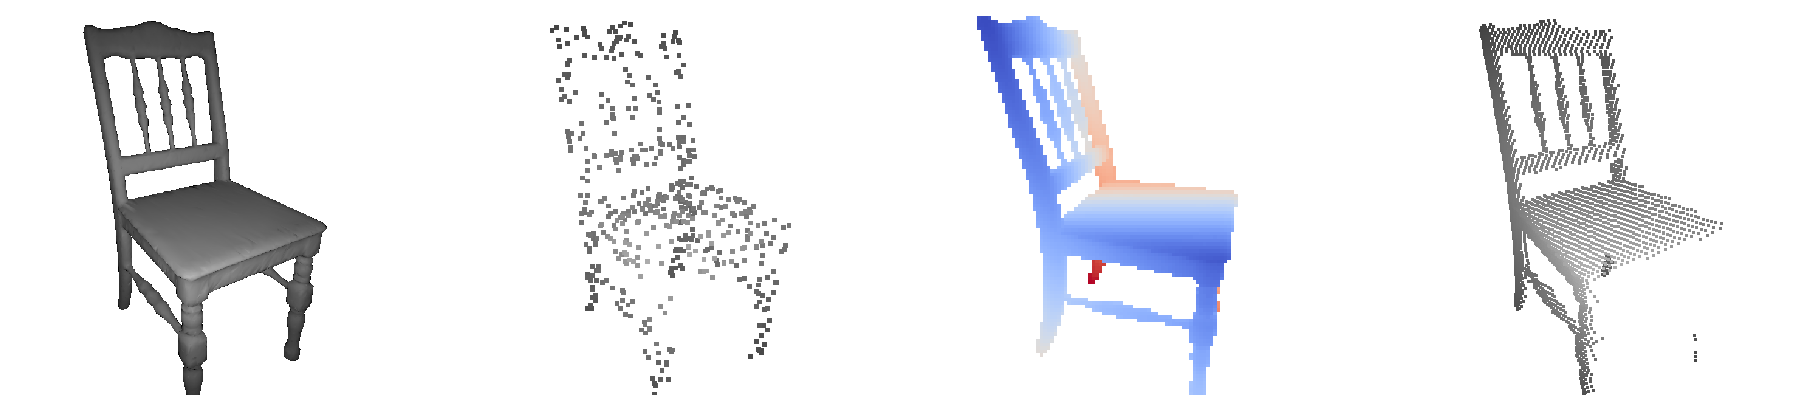

In [9]:
# view point
eye_1 = [.8, .4, .5]
eye_2 = [.3, .4, .9]
center = [0, 0, 0]
up = [0, 1, 0]

def rgb2rgba(rgb):
    """remove white background."""
    rgb = rgb.copy() / 255.
    alpha = np.linalg.norm(1-rgb, axis=-1) != 0
    alpha = alpha.astype(np.float32)[..., None]
    rgba = np.concatenate([rgb, alpha], axis=-1)
    return rgba

# subsample points
point_subsamp = mesh_gt.sample(512)

img_mesh, _, _, _ = render.render_trimesh(mesh_gt, eye_1, center, up, light_intensity=3)
img_pt_sub, _, _, _ = render.render_trimesh(trimesh.PointCloud(point_subsamp), 
                                            eye_1, center, up, light_intensity=3, point_size=8)
# virtual scan (view 2) and unproject depth
_, scan_depth, world2cam, cam2img = render.render_trimesh(mesh_gt, eye_2, center, up, res=(112, 112))
points_unproj = render.unproject_depth_img(scan_depth, cam2img, world2cam)
img_pt_dep, _, _, _ = render.render_trimesh(trimesh.PointCloud(points_unproj), 
                                            eye_1, center, up, light_intensity=3, point_size=5)

size_per_fig = 8
fig, axes = plt.subplots(figsize=(size_per_fig*4, size_per_fig), ncols=4)
axes[0].imshow(rgb2rgba(img_mesh))
axes[0].axis('off')
# axes[0].set_title("Ground Truth Mesh")

axes[1].imshow(rgb2rgba(img_pt_sub))
axes[1].axis('off')
# axes[1].set_title("Sparse Point Samples")

d = scan_depth.copy()
d[scan_depth==0] = np.nan
axes[2].imshow(d, cmap='coolwarm')
axes[2].axis('off')
# axes[2].set_title("Depth Scan")

axes[3].imshow(rgb2rgba(img_pt_dep))
axes[3].axis('off')
# axes[3].set_title("Scanned Points (view 1)")

plt.show()

### Optimize for the latent code corresponding to point observations

In [10]:
embedder = LatentEmbedder(point_dataset, mesh_dataset, deformer, topk=5)

In [11]:
# inputs = input_points[:2048] 
# inputs = points_unproj
inputs = mesh_gt.sample(300) + np.random.randn(300, 3) * 0.005
input_pts = torch.tensor(inputs)[None].to(device)
lat_codes_pre, lat_codes_post = embedder.embed(input_pts, matching="two_way", verbose=True, lr=1e-2, embedding_niter=30, finetune_niter=30, bs=8, seed=1)

Iter: 0, Loss: 0.0808, Dist: 0.0808, Deformation Magnitude: 0.1406, Time per iter (s): 9.2943
Iter: 1, Loss: 0.0834, Dist: 0.0834, Deformation Magnitude: 0.1530, Time per iter (s): 7.9423
Iter: 2, Loss: 0.0751, Dist: 0.0751, Deformation Magnitude: 0.1677, Time per iter (s): 8.3007
Iter: 3, Loss: 0.0724, Dist: 0.0724, Deformation Magnitude: 0.1391, Time per iter (s): 8.8980
Iter: 4, Loss: 0.0677, Dist: 0.0677, Deformation Magnitude: 0.1617, Time per iter (s): 8.5068
Iter: 5, Loss: 0.0637, Dist: 0.0637, Deformation Magnitude: 0.1141, Time per iter (s): 8.1754
Iter: 6, Loss: 0.0577, Dist: 0.0577, Deformation Magnitude: 0.1234, Time per iter (s): 9.7589
Iter: 7, Loss: 0.0566, Dist: 0.0566, Deformation Magnitude: 0.1534, Time per iter (s): 11.4066
Iter: 8, Loss: 0.0514, Dist: 0.0514, Deformation Magnitude: 0.1340, Time per iter (s): 11.7381
Iter: 9, Loss: 0.0498, Dist: 0.0498, Deformation Magnitude: 0.1693, Time per iter (s): 15.2752
Iter: 10, Loss: 0.0516, Dist: 0.0516, Deformation Magnitu

In [ ]:
# np.save("lat_codes_pre_tune.npy", lat_codes_pre)
# lat_codes = np.load("lat_codes_tune.npy")

In [23]:
# retrieve, save results
deformed_meshes, orig_meshes, dist = embedder.retrieve(lat_codes_post, tar_pts=inputs, matching="two_way")

In [27]:
type(dist)

list

In [28]:
asort = np.argsort(dist)
dist = [dist[i] for i in asort]
deformed_meshes_ = [deformed_meshes[i] for i in asort]
orig_meshes_ = [orig_meshes[i] for i in asort]

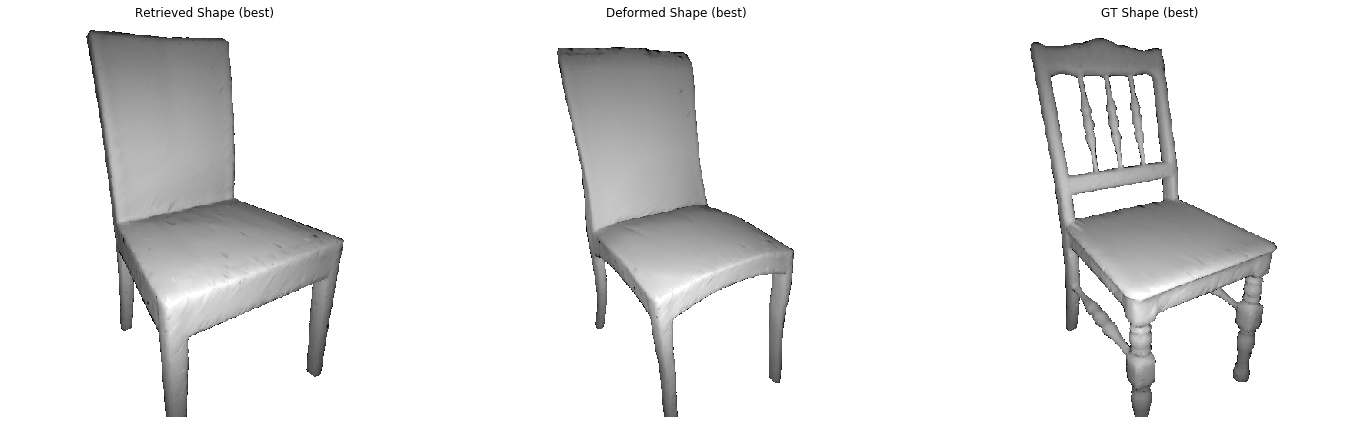

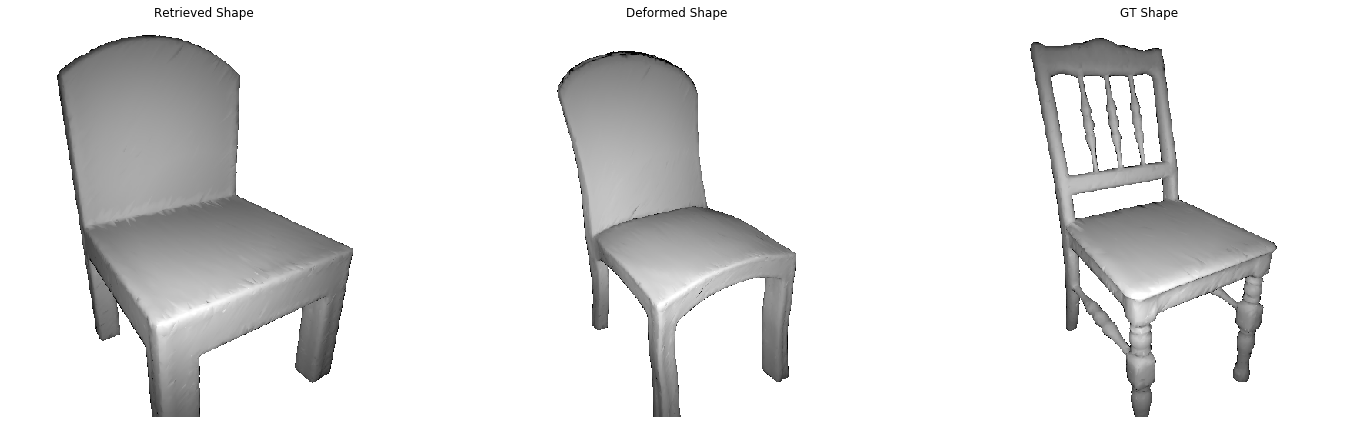

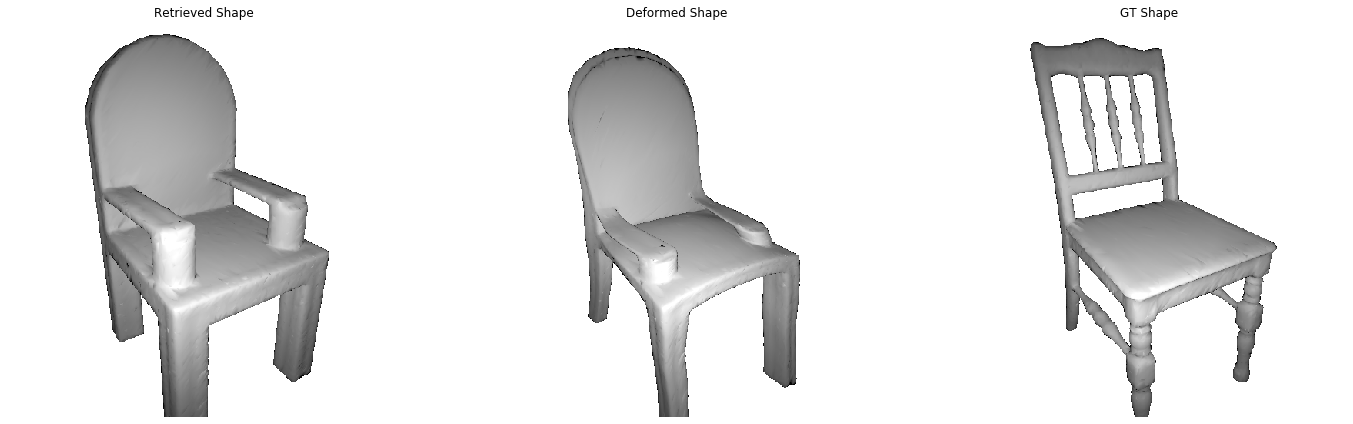

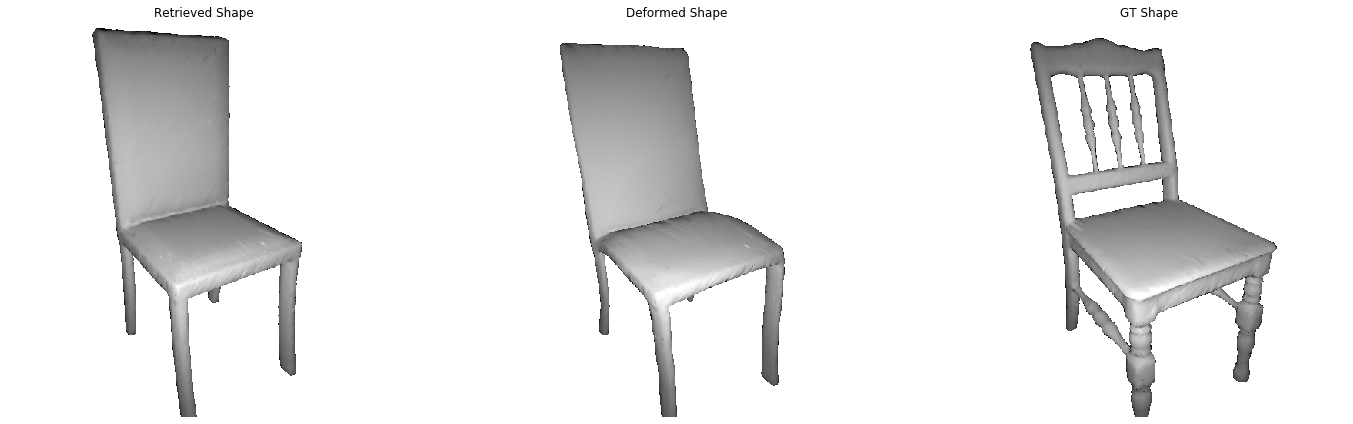

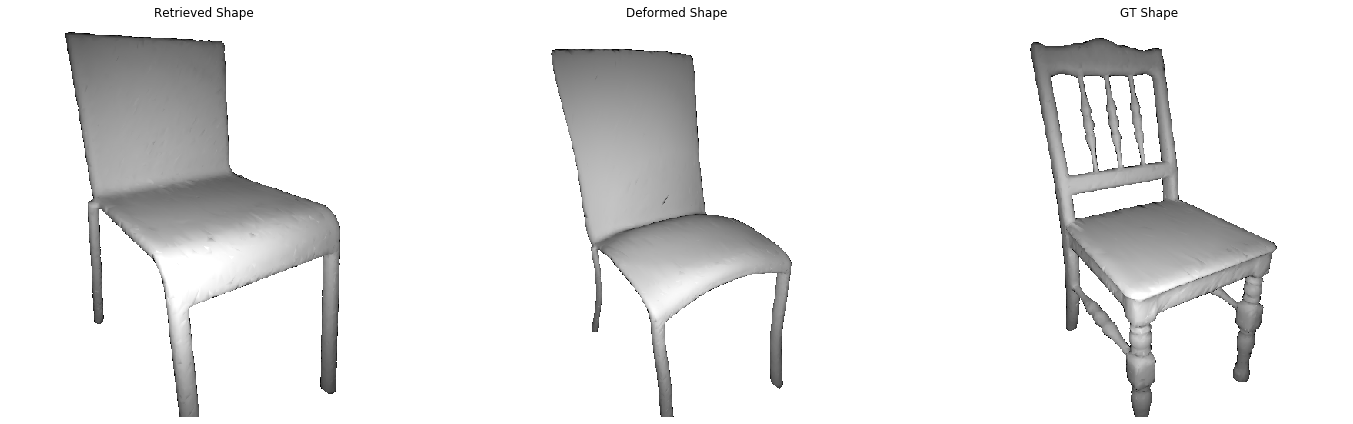

In [29]:
# pick_idx = np.argmin(dist)
for pick_idx in range(5):
    v, f = deformed_meshes_[pick_idx]
    mesh = trimesh.Trimesh(v, f)
    vo, fo = orig_meshes_[pick_idx]
    mesh_o = trimesh.Trimesh(vo, fo)
    img_orig, _, _, _ = render.render_trimesh(mesh_o.copy(), eye_1, center, up, res=(512,512), light_intensity=8)
    colors = np.zeros_like(inputs[:512]); colors[:, 1] = 1.;
    img_def, _, _, _ = render.render_trimesh([mesh.copy(),
                                             ],#trimesh.PointCloud(inputs[:512], colors=colors)], 
                                             eye_1, center, up, res=(512,512), light_intensity=8,
                                             point_size=5)
    img_gt, _, _, _ = render.render_trimesh(mesh_gt.copy(), eye_1, center, up, res=(512,512), light_intensity=8)
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(24, 8))
    best = " (best)" if pick_idx == np.argmin(dist) else ""
    axes[0].imshow(rgb2rgba(img_orig))
    axes[0].axis('off')
    axes[0].set_title("Retrieved Shape"+best)
    axes[1].imshow(rgb2rgba(img_def))
    axes[1].axis('off')
    axes[1].set_title("Deformed Shape"+best)
    axes[2].imshow(rgb2rgba(img_gt))
    axes[2].axis('off')
    axes[2].set_title("GT Shape"+best)
    plt.axis('off')
    plt.show()

In [ ]:
# meshes_ = meshes[0]
# os.makedirs("retrieval", exist_ok=True)
# # save point cloud
# pc = np.savetxt("retrieval/input_points.xyz", inputs, delimiter=' ')
# for idx, (v, f) in enumerate(meshes_):
#     m = trimesh.Trimesh(v, f)
#     m.export(f"retrieval/mesh_{idx}.ply")

## Visualize intermediate flow field

In [ ]:
lat_codes_ = torch.tensor(lat_codes_post).to(embedder.device)
lat_src = torch.zeros_like(lat_codes_)
lat_src_tar = torch.stack([lat_src, lat_codes_], dim=1)
_ = embedder.deformer.net.update_latents(lat_src_tar)

# create query grid
r0, r1, r2 = 6, 11, 6
b = mesh.bounding_box.bounds
s = 0.05
xyz_grid = torch.stack(torch.meshgrid(torch.linspace(b[0,0]-s, b[1,0]+s, r0),
                                      torch.linspace(b[0,1]-s, b[1,1]+s, r1),
                                      torch.linspace(b[0,2]-s, b[1,2]+s, r2)), dim=-1)
xyz_pt = xyz_grid.reshape(1, -1, 3).to(embedder.device)
vel = embedder.deformer.net(torch.tensor(0.5), xyz_pt)
vel_np = vel.detach().cpu().numpy().reshape(r0, r1, r2, 3)
xyz_np = xyz_pt.detach().cpu().numpy().reshape(r0, r1, r2, 3)

# vsamp, fid = mesh.sample(100, return_index=True)
# nsamp = mesh.face_normals[fid]
# query_pt = vsamp + 0.05 * nsamp
# query_vel = embedder.deformer.net(torch.tensor(0.5), torch.from_numpy(query_pt[None].astype(np.float32)).to(embedder.device))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = [-.2, .2] # ax.get_xlim3d()
    y_limits = [-.2, .2] # ax.get_ylim3d()
    z_limits = [-.5, .5] # ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.view_init(elev=30, azim=-30)

v = mesh.copy().vertices
xyz = xyz_np.reshape(-1, 3)
uvw = vel_np.reshape(-1, 3)

ax.plot_trisurf(v[:, 0], v[:, 2], v[:, 1], triangles=mesh.faces, color=np.ones(3), linewidth=0.2)
ax.quiver(xyz[:, 0], xyz[:, 2], xyz[:, 1],
          uvw[:, 0], uvw[:, 2], uvw[:, 1],
          length=0.05, color="black", normalize=True)

ax.set_axis_off()
set_axes_equal(ax)
# plt.savefig("flow.pdf")